### Mulitnomial Naive Bayes

Multinomial naive bayes is performed on a clinical data set with patient demographics and tumor attributes. The label is the survival status of the patient.

#### Step 1: Data Prep

The raw data is not discrete so continous variables need to be descritized, and categorical variables need to be encoded with one hot encoding.

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OrdinalEncoder

In [30]:
## load data and examine head of data
import pandas as pd
filename = "cleaned_cgga_693_clinical.csv"
df = pd.read_csv(filename)
df.head()

,sample_id,tumor_type,tumor_histology,tumor_grade,gender,age,survival_days,survival_status,radio_status,chemo_status,mutation_status,codeletion_status
0,1002,P,anaplastic astrocyma,3,F,43.0,305.0,1.0,1.0,1.0,Wildtype,Non-codel
1,1003,P,oligodendroglioma,2,F,47.0,3817.0,0.0,0.0,1.0,Mutant,Codel
2,1010,P,astrocytoma,2,M,45.0,246.0,1.0,1.0,1.0,Mutant,Non-codel
3,1012,R,oligodendroglioma,2,M,45.0,3679.0,1.0,1.0,1.0,Mutant,Non-codel
4,1014,P,astrocytoma,2,M,42.0,263.0,1.0,0.0,1.0,Wildtype,Non-codel


In [31]:
# drop unnecessary or redundant columns
df = df.drop(columns=['sample_id','survival_days'])
df.head()

,tumor_type,tumor_histology,tumor_grade,gender,age,survival_status,radio_status,chemo_status,mutation_status,codeletion_status
0,P,anaplastic astrocyma,3,F,43.0,1.0,1.0,1.0,Wildtype,Non-codel
1,P,oligodendroglioma,2,F,47.0,0.0,0.0,1.0,Mutant,Codel
2,P,astrocytoma,2,M,45.0,1.0,1.0,1.0,Mutant,Non-codel
3,R,oligodendroglioma,2,M,45.0,1.0,1.0,1.0,Mutant,Non-codel
4,P,astrocytoma,2,M,42.0,1.0,0.0,1.0,Wildtype,Non-codel


In [32]:
# descritize continous features
from sklearn.preprocessing import KBinsDiscretizer

In [33]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
df['age_binned'] = discretizer.fit_transform(df[['age']])

In [34]:
# retrieve bin edges to interpret output of NB model later
bin_edges = discretizer.bin_edges_[0]
print(bin_edges)

[11. 33. 40. 46. 55. 76.]


In [35]:
df.head()

,tumor_type,tumor_histology,tumor_grade,gender,age,survival_status,radio_status,chemo_status,mutation_status,codeletion_status,age_binned
0,P,anaplastic astrocyma,3,F,43.0,1.0,1.0,1.0,Wildtype,Non-codel,2.0
1,P,oligodendroglioma,2,F,47.0,0.0,0.0,1.0,Mutant,Codel,3.0
2,P,astrocytoma,2,M,45.0,1.0,1.0,1.0,Mutant,Non-codel,2.0
3,R,oligodendroglioma,2,M,45.0,1.0,1.0,1.0,Mutant,Non-codel,2.0
4,P,astrocytoma,2,M,42.0,1.0,0.0,1.0,Wildtype,Non-codel,2.0


In [36]:
df=df.drop(columns='age', axis = 1)
df.head()

,tumor_type,tumor_histology,tumor_grade,gender,survival_status,radio_status,chemo_status,mutation_status,codeletion_status,age_binned
0,P,anaplastic astrocyma,3,F,1.0,1.0,1.0,Wildtype,Non-codel,2.0
1,P,oligodendroglioma,2,F,0.0,0.0,1.0,Mutant,Codel,3.0
2,P,astrocytoma,2,M,1.0,1.0,1.0,Mutant,Non-codel,2.0
3,R,oligodendroglioma,2,M,1.0,1.0,1.0,Mutant,Non-codel,2.0
4,P,astrocytoma,2,M,1.0,0.0,1.0,Wildtype,Non-codel,2.0


In [37]:
# use one hot encoding to tranform catagorical feautures

from sklearn.preprocessing import OneHotEncoder

#  categorical columns to encode
categorical_cols = ['tumor_type', 'tumor_histology', 'tumor_grade',
                    'gender','radio_status','chemo_status','mutation_status',
                    'codeletion_status','age_binned']  

# fit encoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(df[categorical_cols])

# get the new column names
encoded_cols = encoder.get_feature_names_out(categorical_cols)

# turn back into a DataFrame
encoded_df = pd.DataFrame(X_encoded, columns=encoded_cols, index=df.index)

# drop original columns and join the new encoded ones
df = df.drop(columns=categorical_cols).join(encoded_df)
df.head()


/Users/julianazweng/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,survival_status,tumor_type_P,tumor_type_R,tumor_histology_anaplastic astrocyma,tumor_histology_anaplastic oligoastrocytoma,tumor_histology_astrocytoma,tumor_histology_glioblastoma,tumor_histology_oligoastrocytoma,tumor_histology_oligodendroglioma,tumor_grade_2,...,chemo_status_1.0,mutation_status_Mutant,mutation_status_Wildtype,codeletion_status_Codel,codeletion_status_Non-codel,age_binned_0.0,age_binned_1.0,age_binned_2.0,age_binned_3.0,age_binned_4.0
0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### Step 2: Split data into training and testing

In [38]:
training, testing = train_test_split(df, test_size=.3)
##  Save the Labels and then remove them from the Training and Testing data
training_label = training["survival_status"]
training=training.drop(["survival_status"], axis=1)
testing_label = testing["survival_status"]
testing=testing.drop(["survival_status"], axis=1)
print("Testing:", testing)

Testing:      tumor_type_P  tumor_type_R  tumor_histology_anaplastic astrocyma  \
213           1.0           0.0                                   0.0   
149           1.0           0.0                                   1.0   
591           0.0           1.0                                   1.0   
478           1.0           0.0                                   0.0   
27            1.0           0.0                                   0.0   
..            ...           ...                                   ...   
75            1.0           0.0                                   1.0   
49            1.0           0.0                                   0.0   
203           1.0           0.0                                   0.0   
421           0.0           1.0                                   0.0   
348           1.0           0.0                                   0.0   

     tumor_histology_anaplastic oligoastrocytoma  tumor_histology_astrocytoma  \
213                              

In [39]:
print("Testing labels:", testing_label)

Testing labels: 213    1.0
149    1.0
591    1.0
478    0.0
27     1.0
      ... 
75     1.0
49     0.0
203    1.0
421    0.0
348    1.0
Name: survival_status, Length: 185, dtype: float64


In [40]:
testing.head()

,tumor_type_P,tumor_type_R,tumor_histology_anaplastic astrocyma,tumor_histology_anaplastic oligoastrocytoma,tumor_histology_astrocytoma,tumor_histology_glioblastoma,tumor_histology_oligoastrocytoma,tumor_histology_oligodendroglioma,tumor_grade_2,tumor_grade_3,...,chemo_status_1.0,mutation_status_Mutant,mutation_status_Wildtype,codeletion_status_Codel,codeletion_status_Non-codel,age_binned_0.0,age_binned_1.0,age_binned_2.0,age_binned_3.0,age_binned_4.0
213,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
149,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
591,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
478,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
27,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [41]:
training.head()

,tumor_type_P,tumor_type_R,tumor_histology_anaplastic astrocyma,tumor_histology_anaplastic oligoastrocytoma,tumor_histology_astrocytoma,tumor_histology_glioblastoma,tumor_histology_oligoastrocytoma,tumor_histology_oligodendroglioma,tumor_grade_2,tumor_grade_3,...,chemo_status_1.0,mutation_status_Mutant,mutation_status_Wildtype,codeletion_status_Codel,codeletion_status_Non-codel,age_binned_0.0,age_binned_1.0,age_binned_2.0,age_binned_3.0,age_binned_4.0
449,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
176,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
501,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
345,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
74,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


#### Step 3: Run Multinomial NB and produce confusion matrix

MultinomialNB()
[0. 1.]
[1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1.
 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1.]
The Multinomial NB Model Prediction Probabilities are:
[[0.013 0.987]
 [0.498 0.502]
 [0.201 0.799]
 [0.93  0.07 ]
 [0.178 0.822]
 [0.534 0.466]
 [0.01  0.99 ]
 [0.004 0.996]
 [0.072 0.928]
 [0.915 0.085]
 [0.417 0.583]
 [0.994 0.006]
 [0.915 0.085]
 [0.949 0.051]
 [0.987 0.013]
 [0.335 0.665]
 [0.629 0.371]
 [0.008 0.992]
 [0.982 0.018]
 [0.108 0.892]
 [0.243 0.757]
 [0.011 0.989]
 [0.477 0.523]
 [0.065 0.93

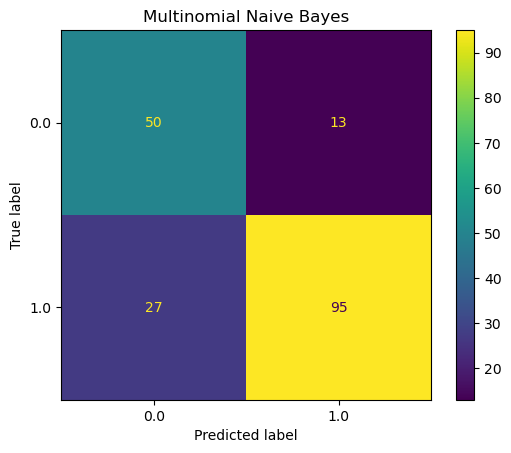

In [45]:
MyMN = MultinomialNB()

## Traing the model
My_MN_Model = MyMN.fit(training, training_label)
print(My_MN_Model)
print(My_MN_Model.classes_)

## Predict the Testing Data using the model
Predictions_MN=My_MN_Model.predict(testing)
print(Predictions_MN)

## Print the actual probabilities
print("The Multinomial NB Model Prediction Probabilities are:")
print(My_MN_Model.predict_proba(testing).round(3))

## Confusion Matrix
CM_MN = confusion_matrix(testing_label, Predictions_MN)
print(CM_MN)
## Pretty confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=CM_MN,display_labels=My_MN_Model.classes_)
disp.plot()
plt.title("Multinomial Naive Bayes")
plt.show()